In [1]:
import os
os.sys.path.append('../neural_net/lib/')
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import evaluate

test_set_meta = pd.read_csv('../data/RIbench/BMTestSets_meta.csv', index_col=0)

def get_y(file):
    fileid = int(file.split('/')[-1].split('_')[0])
    target = (
        test_set_meta[test_set_meta.Index==fileid].GT_LRL.values[0],
        test_set_meta[test_set_meta.Index==fileid].GT_URL.values[0],
        test_set_meta[test_set_meta.Index==fileid].nonp_mu.values[0],
        test_set_meta[test_set_meta.Index==fileid].nonp_sigma.values[0],
        test_set_meta[test_set_meta.Index==fileid].nonp_lambda.values[0],
        test_set_meta[test_set_meta.Index==fileid].nonp_shift.values[0]        
    )
    return np.array(target)

dr = './refineR_predictions/'

def get_files_in_folder(folder_path):
    file_list = []
    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            file_list.append(file_path)
    return file_list
files_test = get_files_in_folder(dr)


In [2]:
# parse the refineR output CSV files and the RIbench metadata file
# for predictions and ground truth values

p_test = []
y_test = []
for i in files_test:
    try:
        p_test.append(pd.read_csv(dr+('/').join(i.split('/')[-2:]))['PointEst'].values)
        y = get_y(i)
    except:
        p_test.append([np.nan, np.nan])
        y = np.ones(6)*np.nan
    if 'CRP' in i:
        y[0]=0
    y_test.append(y)
p_test = np.vstack(p_test)
y_test = np.vstack(y_test)


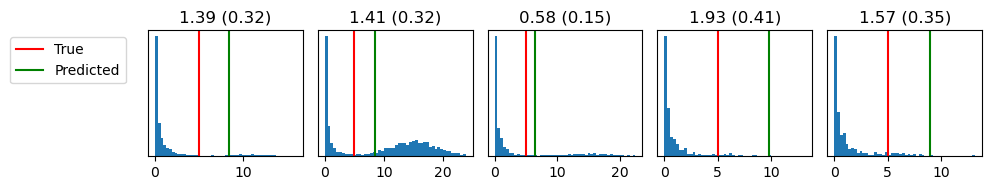

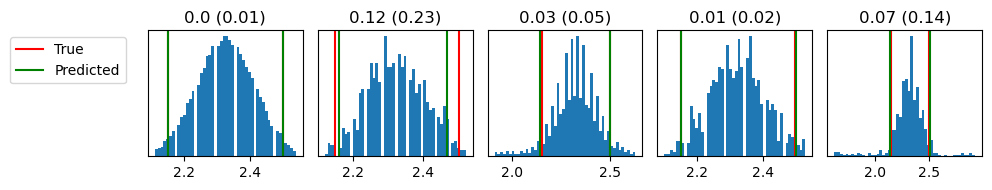

In [3]:
# this is for generating plots that demonstrates how the z-score deviation can be more misleading than
# the proposed norm. error for highly skewed distributions

def plot_examples(p_test, y_test, files_test, analyte='CRP'):
    
    ans_test = np.array([i.split('/')[-2] for i in files_test])

    nr = 5
    plt.figure(figsize=(10,2), dpi=100)
    sample = np.where(ans_test==analyte)[0]
    sample = np.random.choice(sample, len(sample), replace=0)
    for c,i in enumerate(sample[:nr]):
        plt.subplot(1, nr, c+1)
        data = pd.read_csv(files_test[i].replace('./refineR_predictions/',
                                                 '../data/RIbench/Data/'), 
                           header=None).values
        data = data[(data>=np.quantile(data,0.01)) & (data<=np.quantile(data,0.99))]
        y = y_test[i]
        p = p_test[i] 

        if analyte=='CRP':
            xt = evaluate.zscore_transform(p[1], y[2], y[3], y[4], y[5])
            yt = evaluate.zscore_transform(y[1], y[2], y[3], y[4], y[5])
            zs = np.abs(xt-yt)
            normy, nrmp = evaluate.normp(y, p)
            normerr = np.abs(normy[1]-nrmp[1])
        else:
            zs = evaluate.zscore_deviation(y, p)
            normy, nrmp = evaluate.normp(y, p)
            normerr = np.mean(np.abs(normy-nrmp))

        plt.hist(data, 50, density=True);
        if not analyte=='CRP':
            plt.axvline(y[0], c='r')
            plt.axvline(p[0], c='g')
        plt.axvline(y[1], c='r', label='True')
        plt.axvline(p[1], c='g', label='Predicted')
        if c==0:
            plt.legend(bbox_to_anchor=(-0.1,1))
        plt.gca().set_yticks([])
        plt.title(str(round(normerr,2))+' ('+str(round(zs,2))+')')

    plt.gcf().patch.set_facecolor('white')
    plt.gcf().tight_layout()
    
plot_examples(p_test, y_test, files_test, analyte='CRP')
plot_examples(p_test, y_test, files_test, analyte='Ca')


In [4]:
groups = ['Hb', 'Ca', 'FT4', 'AST', 'LACT', 'GGT', 'TSH', 'IgE', 'CRP', 'LDH']

zscore_devs, norm_errors = evaluate.compute_scores(groups, p_test, y_test, files_test)

df = pd.DataFrame({'analyte': groups,
                   'zscore_dev': zscore_devs,
                   'norm_errors': norm_errors})
df


LDH  -  0.045  z-score dev. nan's


,analyte,zscore_dev,norm_errors
0,Hb,0.195802,0.099901
1,Ca,0.129852,0.066336
2,FT4,0.332486,0.149393
3,AST,0.169273,0.073552
4,LACT,0.335133,0.112392
5,GGT,0.400991,0.178434
6,TSH,0.245299,0.077877
7,IgE,0.223082,0.196535
8,CRP,0.289680,1.313918
9,LDH,0.583723,0.292876


In [5]:
print('Average z-score deviation:\t', df.zscore_dev.mean())
print('Average norm. error:\t\t', df.norm_errors.mean())
print('Average norm. error: (w/o CRP)\t\t', df[df.analyte!='CRP'].norm_errors.mean())
print('Average norm. error: (w/o CRP or LDH)\t\t', df[(df.analyte!='CRP') & (df.analyte!='LDH')].norm_errors.mean())


Average z-score deviation:	 0.2905322534350736
Average norm. error:		 0.25612144405071186
Average norm. error: (w/o CRP)		 0.13858847673081204
Average norm. error: (w/o CRP or LDH)		 0.11930257166502564


In [6]:
# error by skew group
groups = [['Hb', 'Ca', 'FT4'], ['AST', 'LACT', 'GGT'], ['TSH', 'IgE'], ['LDH']]

zscore_devs, norm_errors = evaluate.compute_scores(groups, p_test, y_test, files_test)

df = pd.DataFrame({'analyte': groups,
                   'zscore_dev': zscore_devs,
                   'norm_errors': norm_errors})
df


['LDH']  -  0.045  z-score dev. nan's


,analyte,zscore_dev,norm_errors
0,"[Hb, Ca, FT4]",0.222261,0.106119
1,"[AST, LACT, GGT]",0.302841,0.121176
2,"[TSH, IgE]",0.234191,0.137206
3,[LDH],0.583723,0.292876
